# Introduction
In this exercise, we're going to do Natural Language Processing (NLP) regarding disaster tweets. The data used for this is retrieved at the following [link](https://www.kaggle.com/c/nlp-getting-started/overview). 

In [123]:
# Importing the necessary modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize.regexp import regexp_tokenize
from langdetect import detect
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from wordcloud import WordCloud
import scipy.stats as stats
import random
import re
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

# Data preparation
In this chapter, the data will be imported and cleaned to make it ready for our data analysis

## Data import

In [124]:
# Import the data using pandas
trainset = pd.read_csv("train.csv")
testset = pd.read_csv("test.csv")

trainset.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## Cleaning
In this paragraph, we'll clean the two datasets. We'll do that by performing the next steps:
- Dealing with null values
- Cleaning text for keyword and location column
- Cleaning text data (remove url, HTMLs, emojies, hastags)
- Remove unnecessary features

In [125]:
# Check the datasets using the info method
display(trainset.info())
display(testset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


None

### Dealing with null values

In [126]:
print(f"Null values per column for the train set :\n{trainset.isnull().sum()}")
print(f"Null values per column for the test set:\n{testset.isnull().sum()}")

Null values per column for the train set :
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64
Null values per column for the test set:
id             0
keyword       26
location    1105
text           0
dtype: int64


In [127]:
# Check percentage of null values per column for both datasets
print(f"Null values percentage per column for the train set :\n{trainset.isnull().sum() / trainset.shape[0]}")
print(f"Null values percentage per column for the test set:\n{testset.isnull().sum() / testset.shape[0]}")

Null values percentage per column for the train set :
id          0.000000
keyword     0.008013
location    0.332720
text        0.000000
target      0.000000
dtype: float64
Null values percentage per column for the test set:
id          0.000000
keyword     0.007968
location    0.338645
text        0.000000
dtype: float64


**Findings**

What we see here is that for both train and test set, there are two columns with null values: `location` and `keyword`. For the location column, around 1/3th of the column has no values, whilst the keyword column only has about 0.8 percent of missing data. Since their're both text columns with lots of variety, our choice is to change the NaN values with: "no location" and "no keyword"

In [128]:
# Fill the na values with either the no_location or no_keyword
trainset = trainset.fillna(value = {'location': 'no location', 'keyword': 'no keyword'})
testset = testset.fillna(value = {'location': 'no location', 'keyword': 'no keyword'})

# Print the null values per column to see if the fill method worked
print(f"Null values per column for the train set :\n{trainset.isnull().sum()}")
print(f"Null values per column for the test set:\n{testset.isnull().sum()}")

Null values per column for the train set :
id          0
keyword     0
location    0
text        0
target      0
dtype: int64
Null values per column for the test set:
id          0
keyword     0
location    0
text        0
dtype: int64


### Cleaning text for keyword and location column

In [129]:
# Create a function that clean the text columns: clean_text
def clean_text(series):
    # Lower to lowercase for each word
    series = series.apply(lambda x: x.lower())
    
    # Replace numbers with 'number'
    pattern = r"[0-9]"
    series = series.apply(lambda x: re.sub(pattern, ' number ', x))
    
    # Remove special character
    pattern = r"[^a-zA-Z0-9]"
    series = series.apply(lambda x: re.sub(pattern, ' ', x))
    
    # Remove URLs
    pattern = r'http\S+'
    series = series.apply(lambda x: re.sub(pattern, ' ', x))
    
    # Remove emojies
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    
    series = series.apply(lambda x: emoji_pattern.sub(r' emoji ', x))
    
    return series

In [130]:
# Apply clean_data function to the keyword and location columns
columns = ['keyword', 'location', 'text']
trainset[columns] = trainset[columns].apply(lambda x: clean_text(x))
testset[columns] = testset[columns].apply(lambda x: clean_text(x))

trainset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7613 non-null   object
 2   location  7613 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


### Remove unnecesarry features
In this paragraph, we'll remove unnecesarry features from our dataset. This will be the `id` column

In [131]:
trainset_clean = trainset.drop('id', axis = 1)
testset_clean = testset.drop('id', axis = 1)
trainset_clean.head()

,keyword,location,text,target
0,no keyword,no location,our deeds are the reason of this earthquake m...,1
1,no keyword,no location,forest fire near la ronge sask canada,1
2,no keyword,no location,all residents asked to shelter in place are ...,1
3,no keyword,no location,number number number number number peop...,1
4,no keyword,no location,just got sent this photo from ruby alaska as ...,1


## Creating new features
In this paragraph, we'll add new features to the dataset. This is done in order to increase the input for the model training and testing. We'll add the following features:
- Number of tokens used in tweet: n_tokens
- If the tweet is English or not: is_english
- Lenght of location and keyword: len_location and len_keyword
- If the tweet has a location and/or keyword: has_location and has_keyword

### Number of tokens used in tweet: n_tokens

In [132]:
# Create n_tokens feature using regex
trainset_clean['n_tokens'] = [len(regexp_tokenize(line, '\w+')) for line in trainset_clean.text]
testset_clean['n_tokens'] = [len(regexp_tokenize(line, '\w+')) for line in testset_clean.text]

trainset_clean.head()

,keyword,location,text,target,n_tokens
0,no keyword,no location,our deeds are the reason of this earthquake m...,1,13
1,no keyword,no location,forest fire near la ronge sask canada,1,7
2,no keyword,no location,all residents asked to shelter in place are ...,1,22
3,no keyword,no location,number number number number number peop...,1,12
4,no keyword,no location,just got sent this photo from ruby alaska as ...,1,16


### If the tweet is English or not: is_english

In [133]:
# Create function for creating language features
def language(series):
# Create empty list: languages
    languages = []
    
# Detect the langauge of each review using detect
    for i in series:
        lang = detect(i)
        if lang == 'en':
            lang = 1
        else:
            lang = 0
        languages.append(lang)
    
    return languages

In [134]:
trainset_clean['is_english'] = language(trainset_clean.text)
testset_clean['is_english'] = language(testset_clean.text)
testset_clean.head()

,keyword,location,text,n_tokens,is_english
0,no keyword,no location,just happened a terrible car crash,6,1
1,no keyword,no location,heard about earthquake is different cities s...,9,1
2,no keyword,no location,there is a forest fire at spot pond geese are...,19,1
3,no keyword,no location,apocalypse lighting spokane wildfires,4,1
4,no keyword,no location,typhoon soudelor kills number number in chi...,9,1


### Length of keyword and location: len_keyword and len_location

In [135]:
# Function that returns the lenght of the row if the row is not equal to a certain value: len_column
def len_column(series, no_value):
    data = series.apply(lambda x: 0 if x == no_value else len(x))
    
    return data

In [136]:
# Create column that takes the length of each keyword: len_keyword
trainset_clean["len_keyword"] = len_column(trainset_clean.keyword, 'no keyword')
testset_clean["len_keyword"] = len_column(testset_clean.keyword, 'no keyword')

# Create column that takes the lenght of each location
trainset_clean["len_location"] = len_column(trainset_clean.location, 'no location')
testset_clean["len_location"] = len_column(testset_clean.location, 'no location')

trainset_clean.head()

,keyword,location,text,target,n_tokens,is_english,len_keyword,len_location
0,no keyword,no location,our deeds are the reason of this earthquake m...,1,13,1,0,0
1,no keyword,no location,forest fire near la ronge sask canada,1,7,1,0,0
2,no keyword,no location,all residents asked to shelter in place are ...,1,22,1,0,0
3,no keyword,no location,number number number number number peop...,1,12,1,0,0
4,no keyword,no location,just got sent this photo from ruby alaska as ...,1,16,1,0,0


### If the tweet has a location and/or keyword: has_location and has_keyword

In [137]:
trainset_clean['has_keyword'], trainset_clean['has_location'] = (np.where(trainset_clean.len_keyword > 0, 1, 0), 
                                                                np.where(trainset_clean.len_location > 0, 1, 0))
testset_clean['has_keyword'], testset_clean['has_location'] = (np.where(testset_clean.len_keyword > 0, 1, 0), 
                                                                np.where(testset_clean.len_location > 0, 1, 0))

trainset_clean.head()

,keyword,location,text,target,n_tokens,is_english,len_keyword,len_location,has_keyword,has_location
0,no keyword,no location,our deeds are the reason of this earthquake m...,1,13,1,0,0,0,0
1,no keyword,no location,forest fire near la ronge sask canada,1,7,1,0,0,0,0
2,no keyword,no location,all residents asked to shelter in place are ...,1,22,1,0,0,0,0
3,no keyword,no location,number number number number number peop...,1,12,1,0,0,0,0
4,no keyword,no location,just got sent this photo from ruby alaska as ...,1,16,1,0,0,0,0


## Vectorizer 
In this paragraph, we'll vectorize the `text` column of the datasets. This will be done using a TfidfVectorizer.

In [138]:
# Create function that creates a TfidfVectorizer and returns the vector: vectorize
def vectorize(datasets, stop_words, max_features, min_df):
    # Set train and test set based on datasets parameter
    train = datasets[0]
    test = datasets[1]
    
    # Initialize the vectorizer
    vect = TfidfVectorizer(stop_words = stop_words, 
                           max_features = max_features,
                          min_df = min_df)
    
    # Create the vector for the train and test set
    tfidf_train = vect.fit_transform(train)
    tfidf_test = vect.transform(test)
    
    # Create dataframes based on vectors 
    train_df = pd.DataFrame(tfidf_train.A, columns = vect.get_feature_names())
    test_df = pd.DataFrame(tfidf_test.A, columns = vect.get_feature_names())
    
    return (train_df, test_df)

In [139]:
# Set up parameters
stop_words = ['english']
max_features = 1000
min_df = 10
datasets = [trainset_clean.text, testset_clean.text]

# Call vectorize function to vectorize train and test set
train, test = vectorize(datasets, stop_words, max_features, min_df)


# Add the remaining column to the train and test set
cols = ['n_tokens', 'has_location', 'has_keyword', 'len_keyword', 'is_english', 'len_location']
train[cols] = trainset_clean[cols]
test[cols] = testset_clean[cols]

display(train.head())
display(test.head())

,abc,ablaze,about,accident,across,action,actually,added,affected,after,...,youth,youtube,yr,zone,n_tokens,has_location,has_keyword,len_keyword,is_english,len_location
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,13,0,0,0,1,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,7,0,0,0,1,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,22,0,0,0,1,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,12,0,0,0,1,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,16,0,0,0,1,0


,abc,ablaze,about,accident,across,action,actually,added,affected,after,...,youth,youtube,yr,zone,n_tokens,has_location,has_keyword,len_keyword,is_english,len_location
0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6,0,0,0,1,0
1,0.0,0.0,0.339124,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,9,0,0,0,1,0
2,0.0,0.0,0.000000,0.0,0.370473,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,19,0,0,0,1,0
3,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,4,0,0,0,1,0
4,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,9,0,0,0,1,0


# Data analysis
In this chapter, some data analysis will be performed. We'll do that by creating multiple visualizations that enhance our data story with information. We'll also perform multiple hypothesis tests to find possible relationships within the datasets.

## Data visualization
In this chapter, we'll do some data visualization, which will enhance our data story. We'll perform the following visualizations:
- distribution of targets
- distribution of English vs non-English tweets
- 10 most common locations per target
- 10 most common keywords per target
- word cloud of text per target 
- distribution of n_tokens

### Distribution of targets

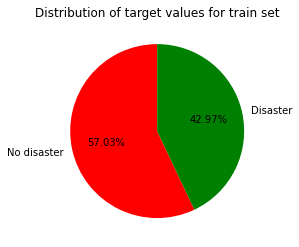

In [140]:
# Find the distribution of the target types
data_train = trainset_clean.target.value_counts(normalize = True)

plt.pie(x = data_train, labels = ["No disaster", "Disaster"], colors = ['red', 'green'],
       autopct = "%0.2f%%", startangle = 90)
plt.title("Distribution of target values for train set")
plt.show()

***Findings***

Based on this graph, it looks like the distribution is pretty good. The amount of non-disaster tweets is a bit higher than disaster tweets

### Distribution of English vs non-English tweets

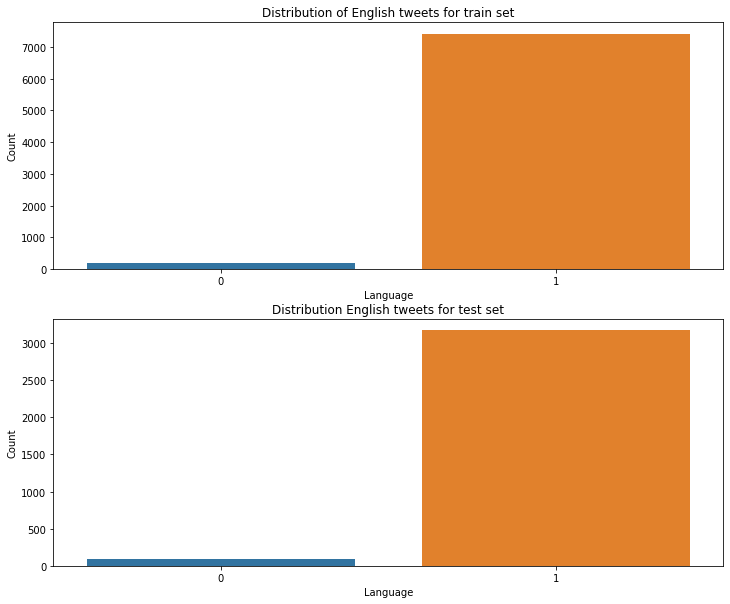

In [141]:
# Find the distribution of languages for train and testset
# Set parameters
datasets = [trainset_clean, testset_clean]
titles = ["Distribution of English tweets for train set", "Distribution English tweets for test set"]

# Create subplots
fig, ax = plt.subplots(figsize = (12, 10), nrows = 2)

for title, data, axes in zip(titles, datasets, ax.flat):
    sns.countplot(x = 'is_english', data = data, ax = axes)
    axes.set_xlabel("Language")
    axes.set_ylabel("Count")
    axes.set_title(title)
    
plt.show()

***Findings***

The distribution for English vs non-English tweets is healivy in favor of English ones. Only a few hundred tweets are non-English

### 10 most common locations per target

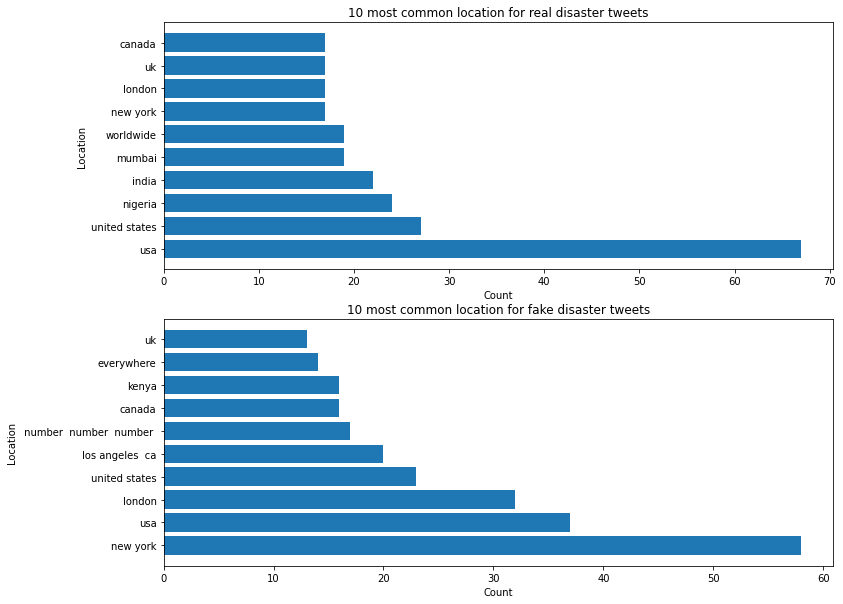

In [142]:
# Find 10 most common locations per target value
disaster = trainset_clean.loc[(trainset_clean.target == 1)
                              & (trainset_clean.location != 'no location'), :]
no_disaster = trainset_clean.loc[(trainset_clean.target == 0)
                                 & (trainset_clean.location != 'no location'), :]

data_disaster = disaster.location.value_counts().sort_values(ascending = False)[:10]
data_no_disaster = no_disaster.location.value_counts().sort_values(ascending = False)[:10]

# Set up parameters for plotting
datasets = [data_disaster, data_no_disaster]
titles = [f"{len(data_disaster)} most common location for real disaster tweets", 
          f"{len(data_no_disaster)} most common location for fake disaster tweets"]

fig, ax = plt.subplots(figsize = (12, 10), nrows = 2)

for data, title, axes in zip(datasets, titles, ax.flat):
    axes.barh(data.index.tolist(), data)
    axes.set_title(title)
    axes.set_ylabel("Location")
    axes.set_xlabel("Count")
plt.show()

***Findings***

It looks like the locations for real disaster tweets are a bit more internationally oriented. Meanwhile, fake disaster tweets are more based on America/Europe.

### 10 most common keywords per target

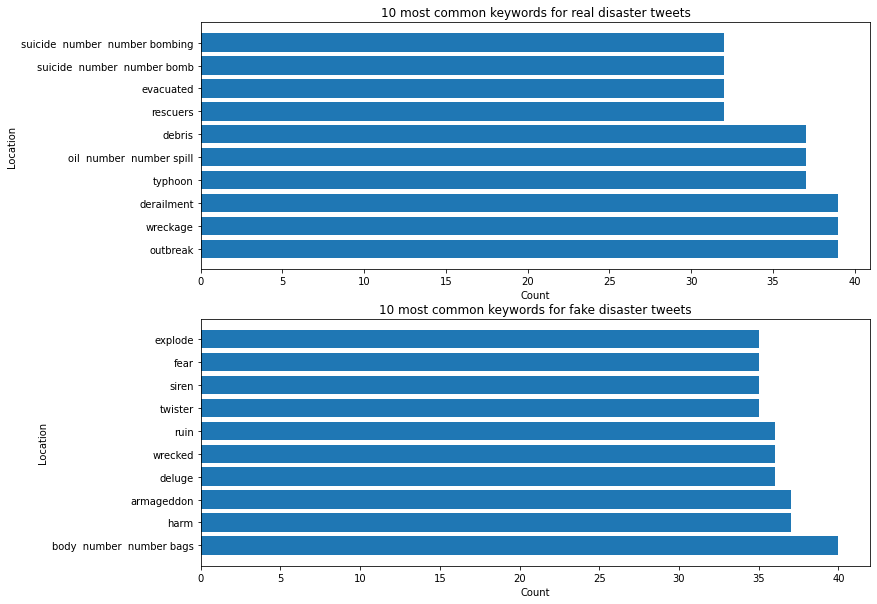

In [143]:
# Find 10 most common keywords per target value
# Leave no keyword value out
disaster = trainset_clean.loc[(trainset_clean.target == 1) 
                              & (trainset_clean.keyword != 'no keyword'), :]
no_disaster = trainset_clean.loc[(trainset_clean.target == 0)
                                 & (trainset_clean.keyword != 'no keyword'), :]

data_disaster = disaster.keyword.value_counts().sort_values(ascending = False)[:10]
data_no_disaster = no_disaster.keyword.value_counts().sort_values(ascending = False)[:10]

# Set up parameters for plotting
datasets = [data_disaster, data_no_disaster]
titles = [f"{len(data_disaster)} most common keywords for real disaster tweets", 
          f"{len(data_no_disaster)} most common keywords for fake disaster tweets"]

fig, ax = plt.subplots(figsize = (12, 10), nrows = 2)

for data, title, axes in zip(datasets, titles, ax.flat):
    axes.barh(data.index.tolist(), data)
    axes.set_title(title)
    axes.set_ylabel("Location")
    axes.set_xlabel("Count")
plt.show()

***Findings***

Based on the graphs, it looks like fake disaster tweets sometimes contains keywords that are not disaster related, e.g armageddon. But mostly, both fake and real tweets usually contain disaster related keywords.

### Word cloud of text per target

In [144]:
def wordcloud(data, title, ax):
    wordcloud = WordCloud(max_font_size=50, max_words=50, background_color="white",
                           width = 500, height = 500, min_word_length = 3).generate(str(data))
    
    # Display the generated image:
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis("off")
    ax.set_title(title, fontsize = 20)

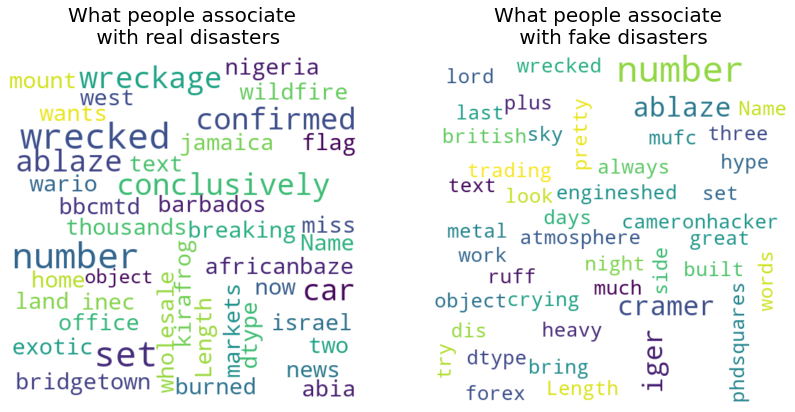

In [145]:
fig, ax = plt.subplots(ncols = 2, figsize = (14, 10))

wordcloud_true = wordcloud(disaster.text, "What people associate \n with real disasters", ax[0])
wordcloud_false = wordcloud(no_disaster.text, "What people associate \n with fake disasters", ax[1])

# Display the generated images
plt.show()

***Findings***

On the wordcloud of real disaster tweets, a word that stands out is confimed and conclusisvely. This shows that if a tweet contains one of these words, it probably is already confimred by serious media outlets or goverments involved. For fake disaster tweets, it's noticed that the word lord comes in, which may indicated that the tweet was created by a heavily religious person.

### Distribution of token length per target

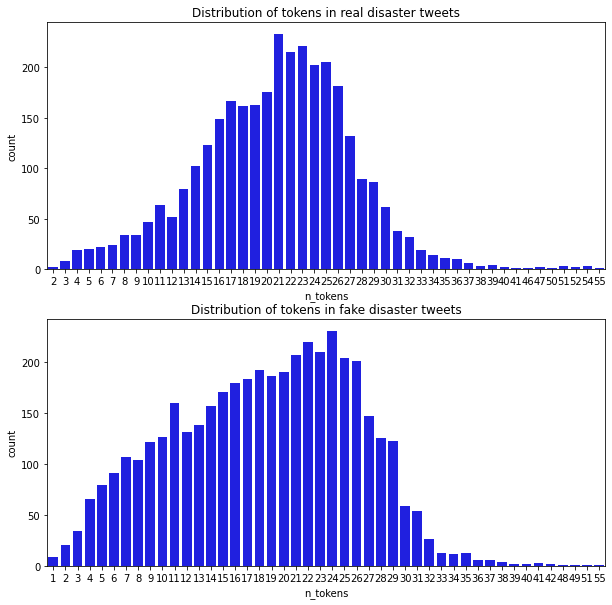

In [146]:
# Create a histogram of n_token per target
fig, ax = plt.subplots(figsize = (10, 10), nrows = 2)
sns.countplot(x = 'n_tokens', data = disaster, ax = ax[0], color = 'blue')
sns.countplot(x = 'n_tokens', data = no_disaster, ax = ax[1], color = 'blue')
ax[0].set_title("Distribution of tokens in real disaster tweets")
ax[1].set_title("Distribution of tokens in fake disaster tweets")
plt.show()

***Findings***

It looks like, fake disaster contain more tweets that have shorter tokens involved. This could indicate that a short disaster tweet, has a higher chance of being fake than a long one.

## Relationships between the data
In this paragraph, we're trying to find relationships within the data. We'll do that by creating a correlation maxtrix, to see if there's any linear relationships. And we'll perform a few hypothesis testing to see if there's any relationships to find.

### Correlation matrix

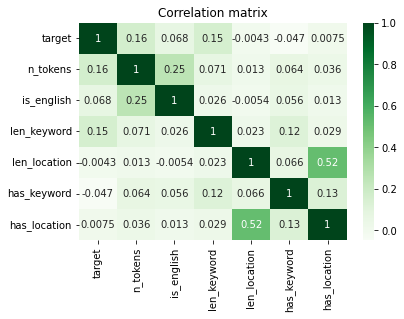

In [147]:
# Create and display the correlation matrix
corr = trainset_clean.corr()

sns.heatmap(corr, annot=True, cmap = 'Greens')
plt.title("Correlation matrix")
plt.show()

***Findings***
Based on the correlation matrix, the following correlatoins are noticed:
- has_location and len_location: this one is pretty obvious, since the has_location column is created based on the len_location column. The same goes for len_keyword and has_keyword.
- n_tokens and is_english: the correlation of these two is 0.28 which indicates of a medium weak positive correlation.
- target and n_tokens and len_keywords: the target a correlation of 0.11 with n_tokens and 0.16 with len_keyword. Both indicates a weak positive correlation with the target column.

### Hypothesis testing.
Based on the correlation matrix and the visualizations brom before, we want to perform some hypothesis testing to find out if there are relationships to find in the data. We want to have a confidence interval of 95%, which means that the p-value has to be at least 0.05 to accept the null-hypothesis.

We want to perform hypothesis testing on the following:
- N_tokens and target
- language and n_token
- language and target
- has_keyword and has_location

In [148]:
# Create a function that performs a hypothesis test: hypothesis_test
def hypothesis_test(data1, data2, test):
    stat, p = test(data1, data2)
    print(f"The p-value is: {p}")
    print(f"The test statistic comes out to be equal to: {stat}")

### N_tokens and target
In order to perform the hypothesis test, we need to define the null hypothesis.

- Null hypothesis: There's no difference in the number of tokens from real disaster tweets, compared to fake disaster tweets.
- Alternative hypothesis 1: Fake disaster tweets have **higher** number of tokens compared to real disaster tweets.
- Alternative hypothesis 2: Fake disaster tweets have **lower** number of tokens compared to real disaster tweets.

In [149]:
# Set up parameters
data1 = disaster.n_tokens.sample(n = 200)
data2 = no_disaster.n_tokens.sample(n = 200)

# Call hypothesis_test to perform hypothesis testing
hypothesis_test(data1, data2, stats.ttest_ind)

The p-value is: 5.476743510935938e-05
The test statistic comes out to be equal to: 4.078493100647088


***Findings***

Based on the t-test, we see that the p-value is lower than 0.05. Hence, we'll reject the null hypothesis. This mean that a fake disaster tweet, generally has a lower amount of tokens than real ones.

### Language and target

- Null hypothesis: There's no difference in the language from real disaster tweets, compared to fake disaster tweets.
- Alternative hypothesis 1: Fake disaster tweets have **higher** change being English compared to real disaster tweets.
- Alternative hypothesis 2: Fake disaster tweets have **lower** change being English compared to real disaster tweets.

In [150]:
# Set up parameters
sample1 = disaster.is_english.sample(n = 100)
sample2 = no_disaster.is_english.sample(n = 100)

# Call hypothesis_test to perform hypothesis testing
hypothesis_test(sample1, sample2, stats.ttest_ind)

The p-value is: 0.043590848792981446
The test statistic comes out to be equal to: 2.031009601158992


***Findings***

Based on the t-test, we see that the p-value is lower than 0.05. Hence, we'll reject the null hypothesis. This mean that a fake disaster tweet, generally has a lower change of being English than real ones.

### Language and n_tokens
- Null hypothesis: English tweets have no difference in number of tokens, compared to non-English tweets.
- Alternative hypothesis 1: English tweets have a **higher** amount of tokens than non-English tweets.
- Alternative hypothesis 2: English tweets have a **lower** amount of tokens than non-English tweets.

In [151]:
# Set up parameters
sample = 100

data1 = trainset_clean.loc[trainset_clean.is_english == 1, :]
data2 = trainset_clean.loc[trainset_clean.is_english == 0, :]

sample1 = data1.n_tokens.sample(n = sample)
sample2 = data2.n_tokens.sample(n = sample)

# Call hypothesis_test to perform hypothesis testing
hypothesis_test(sample1, sample2, stats.ttest_ind)

The p-value is: 6.572410489720294e-22
The test statistic comes out to be equal to: 10.87837930799224


***Findings***

Based on the t-test, we see that the p-value is lower than 0.05. Hence, we'll reject the null hypothesis. This means that a non-English tweets generally have a lower amount of tokens, compared to English tweets.

### has_keyword and has_location
- Null hypothesis: the presence of a keyword in a tweet, **does not increase** the change of the tweet containing a location.
- Alternative hypothesis 1: the presence of a keyword in a tweet, **increases** the change of the tweet containing a location. 
- Alternative hypothesis 2: the presence of a keyword in a tweet, **decreases** the change of the tweet containing a location.

In [152]:
sample = 100
data1 = trainset_clean.loc[trainset_clean.has_location == 1, :]
data2 = trainset_clean.loc[trainset_clean.has_location == 0, :]

sample1 = data1.n_tokens.sample(n = sample)
sample2 = data2.n_tokens.sample(n = sample)

# Call hypothesis_test to perform hypothesis testing
hypothesis_test(sample1, sample2, stats.ttest_ind)

The p-value is: 0.3373062932695968
The test statistic comes out to be equal to: 0.9618336929772114


***Findings***

Based on the test, we see a p-valeu higher than 0.05. Hence, we'll accept the null-hypothesis. This means that the presence of a keyword in a tweet, does not increase the change of the tweet containing a location.

# Models
In this chapter, we'll use multiple models to train and test on a validation set of the data. For this, we'll use the following models:
- MultinomialNB
- K-nearest neighbour
- Neural Network using keras
- Logistic Regression

For each model, we'll list each advantages and disadvantages.

## Model advantages and disadvantages
In this paragraph, we're going to compare the advantages and disadvantages of each model.

### MultinomailNB
**Advantages:**
- It is easy to implement as you only have to calculate probability.
- It is highly scalable and can easily handle large datasets.

**Disadvantages:**
- The prediction accuracy of this algorithm is lower than the other probability algorithms, e.g. logistic regression.
 
### K Nearest Neighbor
**Advantages:**
- KNN is very easy to implement. There are only two parameters required to implement KNN i.e. the value of K and the distance function.

**Disadvantages:**
- The KNN algorithm doesn’t work well with high dimensional data because with large number of dimensions, it becomes difficult for the algorithm to calculate the distance in each dimension.
- KNN is sensitive to noise in the dataset. We need to manually impute missing values and remove outliers.

### Neural network (using Keras)
**Advantages:**
- Neural networks are good to model with nonlinear data with a large number of inputs; for example, images.
- It can perform really well with high amount of data and dimensionality.

**Disadvantages:**
- There is no specific rule for determining the structure of a neural network. The appropriate network structure is achieved through experience and trial and error.
 
At first, we'll prepare the data so that it's ready for model training. Then, we'll instantiate and build the models. After that, each model gets trained and tested on the validation set.

## Data preperation
In this paragraph, we'll prepare the data for the model building.

In [153]:
# Split the train data into train and validation set
y = trainset_clean.target.astype('category')
X_train, X_val, y_train, y_val = train_test_split(train, y, test_size = 0.15, random_state = 42)

## Model building
In this paragraph, the models will be build.

In [154]:
# Instantiate the models
multinb = MultinomialNB()
knn = KNeighborsClassifier()
log_reg = LogisticRegression()

# Set number of columns of X_train: n_cols
n_cols = X_train.shape[1]

# Create the keras model: nn
nn = Sequential()

# Add the first layer
nn.add(Dense(75, activation = "relu", input_shape = (n_cols,)))

# Add the second layer
nn.add(Dense(25, activation = "relu"))

# Add the output layer
nn.add(Dense(2, activation = 'softmax'))

## Model training
In this paragraph, we'll train on the train set for all models. We'll perform GridSearchCV on the models to optimize the parameters and their respective performance.

In [155]:
# Define a function that trains and predicts on gridsearch cv using 
# a model and parameters as input: gridsearch
def gridsearchcv(model, X_train, X_val, y_train, parameters, name):  
    print(f"Performing GridSearchCV on {name}")
    
    # Define grid search
    cv = GridSearchCV(model, parameters, cv=5, scoring = "accuracy", n_jobs = -1)
    cv.fit(X_train, y_train)
    
    # Retrieve the best model
    best_model = cv.best_estimator_
    
    # Print out the best paramaters
    print(f"Best parameters for {name}: {cv.best_params_}")
    
    # Predict on the validation set using the best model
    y_pred = best_model.predict(X_val)
    
    print(f"Performing GridSearchCV done on {name}")
    return y_pred

In [156]:
# Train and predict on the MultinomialNB model using the gridsearchcv model
# Set parameters
params_multinb = {
    "alpha": [0.2, 0.5, 1, 2, 5, 10],
    "fit_prior": [True, False]
}
y_pred_multinb = gridsearchcv(multinb, X_train, X_val, y_train, 
                              params_multinb,  "Naive Bayes")

# Train and predict on the KNN model using the gridsearchcv model
# Set parameters
params_knn = {
    "n_neighbors": [3, 5, 15, 25, 35],
    "weights": ['uniform', 'distance'],
    "leaf_size": [10, 20, 30, 40, 50]
}
y_pred_knn = gridsearchcv(knn, X_train, X_val, y_train, 
                          params_knn, "K Nearest Neighbor")

# Train and predict on the Logestic Regression model using the gridsearchcv model
# Set parameters
params_log_reg = {
    'C': [0.01, 0.1, 0.5, 1.0, 1.5, 2.0],
    'solver': ['newton-cg', 'lbfgs', 'liblinear']
}
y_pred_logreg = gridsearchcv(log_reg, X_train, X_val, y_train, 
                             params_log_reg, "Logistic Regression")

print("GridSearchCV done")

Performing GridSearchCV on Naive Bayes
Best parameters for Naive Bayes: {'alpha': 0.2, 'fit_prior': True}
Performing GridSearchCV done on Naive Bayes
Performing GridSearchCV on K Nearest Neighbor
Best parameters for K Nearest Neighbor: {'leaf_size': 10, 'n_neighbors': 35, 'weights': 'distance'}
Performing GridSearchCV done on K Nearest Neighbor
Performing GridSearchCV on Logistic Regression
Best parameters for Logistic Regression: {'C': 1.5, 'solver': 'newton-cg'}
Performing GridSearchCV done on Logistic Regression
GridSearchCV done


In [157]:
# Train on the keras neural network
# Set parameters
predictors = X_train.values
target = to_categorical(y_train)
validate_pred = X_val.values
target_val = to_categorical(y_val)

nn.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Define early_stopping_monitor
early_stopping_monitor = EarlyStopping(patience = 3, monitor = 'val_accuracy')

# Fit the model
nn.fit(predictors, target, epochs=50, validation_data = [validate_pred, target_val], 
       batch_size=32, callbacks = [early_stopping_monitor])

Epoch 1/50
203/203 [==============================] - 2s 5ms/step - loss: 0.6497 - accuracy: 0.6350 - val_loss: 0.6025 - val_accuracy: 0.6926
Epoch 2/50
203/203 [==============================] - 1s 3ms/step - loss: 0.5153 - accuracy: 0.7654 - val_loss: 0.5164 - val_accuracy: 0.7636
Epoch 3/50
203/203 [==============================] - 1s 3ms/step - loss: 0.4319 - accuracy: 0.8081 - val_loss: 0.5051 - val_accuracy: 0.7872
Epoch 4/50
203/203 [==============================] - 1s 3ms/step - loss: 0.4062 - accuracy: 0.8197 - val_loss: 0.5286 - val_accuracy: 0.7680
Epoch 5/50
203/203 [==============================] - 1s 3ms/step - loss: 0.3841 - accuracy: 0.8306 - val_loss: 0.5216 - val_accuracy: 0.7820
Epoch 6/50
203/203 [==============================] - 1s 3ms/step - loss: 0.3711 - accuracy: 0.8323 - val_loss: 0.5100 - val_accuracy: 0.7898
Epoch 7/50
203/203 [==============================] - 1s 3ms/step - loss: 0.3625 - accuracy: 0.8391 - val_loss: 0.5187 - val_accuracy: 0.7750
Epoch 

## Model testing
In this paragraph, we'll test the models on their performance. We'll use the following metrics:
- Accuracy
- Precision
- Recall
- F1-score
Accuracy is chosen because it gives an overall idea how well a classification model performs. Precision and Recall score is chosen in order to create more insight in the performance of our model. 
And F1-score is chosen because that the main metric in the leaderboard for this Kaggle competition.

The model we'll select for final training and predicting, will mostly be based on F1-score and accuracy.

In [158]:
# Define a function that takes the predicted and actual values
# and print/plots the results
def model_evaluation(true, pred, name):
    # Get the followings scores and print it:
    # Accuracy, precision, recall and f1 score
    acc = accuracy_score(true, pred)
    prec = precision_score(true, pred)
    rec = recall_score(true, pred)
    f1 = f1_score(true, pred)
    
    # Print the results
    print(f"Results model {name}")
    print(f"Accuracy of {name} model: {acc * 100:.3f}%")
    print(f"Precision score of {name} model: {prec * 100:.3f}%")    
    print(f"Recall score of {name} model: {rec * 100:.3f}%")
    print(f"F1 score of {name} model: {f1 * 100:.3f}%")
    
    # Get the confusion matrix and plot it
    conf_matrix = confusion_matrix(true, pred)
    
    fig, ax = plt.subplots()
    sns.heatmap(conf_matrix, annot = True, cbar = False, 
                fmt = 'd', cmap = 'Blues', ax = ax, xticklabels = ["No disaster", "Disaster"],
               yticklabels = ["No disaster", "Disaster"])
    ax.set_xlabel("Predicted values")
    ax.set_ylabel("Actual values")
    ax.set_title(f"Confusion matrix of {name} model")
    plt.show()

In [159]:
# Set parameters for predicting on the neural network
pred_data = X_val.values

pred_nn = nn.predict(pred_data)

# Calculate predicted probability of survival: predicted_prob_true
#predicted_prob_true = pred_nn[:, 1]

validate_pred = X_val.values
target_val = to_categorical(y_val)

# print predicted_prob_true
print("Accuracy of the model on Training Data is -", nn.evaluate(validate_pred,target_val)[1]*100, "%")

# Get predicted outputs
preds = []

for i in range(pred_nn.shape[0]):
    data = pred_nn[i]
    
    if data[0] > data[1]:
        preds.append(0)
    else:
        preds.append(1)

36/36 [==============================] - 0s 2ms/step - loss: 0.5400 - accuracy: 0.7723
Accuracy of the model on Training Data is - 77.23292708396912 %


Results model Naive Bayes - MultinomialNB
Accuracy of Naive Bayes - MultinomialNB model: 69.352%
Precision score of Naive Bayes - MultinomialNB model: 65.986%
Recall score of Naive Bayes - MultinomialNB model: 59.267%
F1 score of Naive Bayes - MultinomialNB model: 62.446%


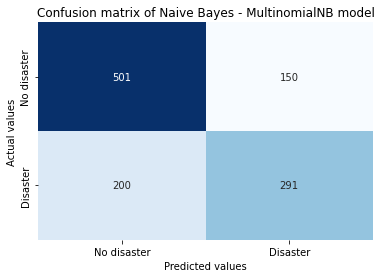

Results model K Nearest Neighbors
Accuracy of K Nearest Neighbors model: 61.996%
Precision score of K Nearest Neighbors model: 57.326%
Recall score of K Nearest Neighbors model: 45.418%
F1 score of K Nearest Neighbors model: 50.682%


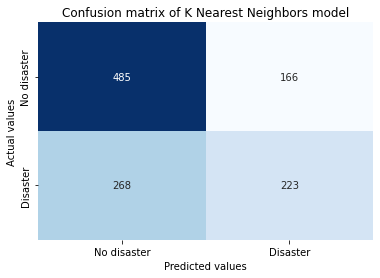

Results model Neural network
Accuracy of Neural network model: 77.233%
Precision score of Neural network model: 73.239%
Recall score of Neural network model: 74.134%
F1 score of Neural network model: 73.684%


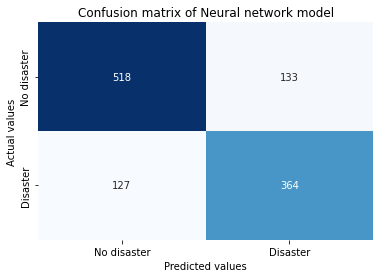

Results model Logistic Regression
Accuracy of Logistic Regression model: 78.196%
Precision score of Logistic Regression model: 78.271%
Recall score of Logistic Regression model: 68.228%
F1 score of Logistic Regression model: 72.905%


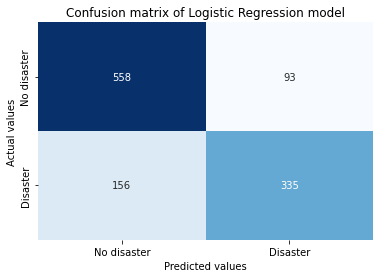

In [160]:
# Call the model_evaluation function on the models
model_evaluation(y_val, y_pred_multinb, "Naive Bayes - MultinomialNB")
model_evaluation(y_val, y_pred_knn, "K Nearest Neighbors")
model_evaluation(y_val, preds, "Neural network")
model_evaluation(y_val, y_pred_logreg, "Logistic Regression")

## Findings
Based on the results of the models, we can conclude the following:
- KNN performs the lowest: 62% accuracy and 50% F1 score
- MultinomialDB performs slightly better: 69% accuracy and 62% F1 score
- The best results are from the neural network and logistic regressino model:
    - Neural network: 77% accuracy and 73,68% F1 score
    - Logistic regression: 78% accuracy and 72,90% F1 score
- The logistic regression model has a slight higher accuracy, but the neural network performs slightly better on the F1. And since the leaderboard is based on the F1 score, we'll choose the neural network.

# Conclusion
Based on this exercise, we can conclude the following:
- The target distribution is pretty equal. In contrast the is_english, only a few hundred tweets are non-English.
- The location of real disasters are more internationally oriented, compared to fake ones.
- There are a few relationships found in the data based on the hypothesis testing:
    - N_tokens and target
    - Language and n_token
    - Language and target
- The neural network and logistic regression are the best models to test based on our selected models. The neural network performs the best on F1 score.

# Final model
In this chapter, we'll train, predict and submit our final model. For this, we'll use our neural network before in this exercise with the same architecture.

## Final model building

In [161]:
# Set number of columns of X_train: n_cols
n_cols = X_train.shape[1]

# Create the keras model: nn
nn_final = Sequential()

# Add the first layer
nn_final.add(Dense(75, activation = "relu", input_shape = (n_cols,)))

# Add the second layer
nn_final.add(Dense(25, activation = "relu"))

# Add the output layer
nn_final.add(Dense(2, activation = 'softmax'))

## Final model training

In [162]:
# Train on the train set
# Set parameters
predictors = train.values
target = to_categorical(trainset_clean.target)

nn_final.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Define early_stopping_monitor
early_stopping_monitor = EarlyStopping(patience = 3, monitor = 'val_accuracy')

# Fit the model
nn_final.fit(predictors, target, epochs=50, validation_split = 0.2, 
       batch_size=32, callbacks = [early_stopping_monitor])

Epoch 1/50
191/191 [==============================] - 1s 4ms/step - loss: 0.6628 - accuracy: 0.6274 - val_loss: 0.6235 - val_accuracy: 0.6809
Epoch 2/50
191/191 [==============================] - 1s 3ms/step - loss: 0.5457 - accuracy: 0.7585 - val_loss: 0.5295 - val_accuracy: 0.7597
Epoch 3/50
191/191 [==============================] - 1s 3ms/step - loss: 0.4674 - accuracy: 0.7916 - val_loss: 0.4659 - val_accuracy: 0.7912
Epoch 4/50
191/191 [==============================] - 1s 3ms/step - loss: 0.4209 - accuracy: 0.8120 - val_loss: 0.4618 - val_accuracy: 0.7846
Epoch 5/50
191/191 [==============================] - 1s 3ms/step - loss: 0.4066 - accuracy: 0.8209 - val_loss: 0.4736 - val_accuracy: 0.7571
Epoch 6/50
191/191 [==============================] - 1s 3ms/step - loss: 0.3943 - accuracy: 0.8228 - val_loss: 0.4500 - val_accuracy: 0.7919
Epoch 7/50
191/191 [==============================] - 1s 3ms/step - loss: 0.3803 - accuracy: 0.8342 - val_loss: 0.4584 - val_accuracy: 0.7794
Epoch 

## Final model predicting

In [163]:
# Predict on the test set
# Set parameters for predicting on the neural network
pred_data = test.values

# Predict on pred_data
pred_nn = nn_final.predict(pred_data)

# Get predicted outputs
preds = []

for i in range(pred_nn.shape[0]):
    data = pred_nn[i]
    
    if data[0] > data[1]:
        preds.append(0)
    else:
        preds.append(1)

102/102 [==============================] - 0s 2ms/step


## Final submission

In [ ]:
# Create final submission dataframe
submission = pd.DataFrame({'id': testset.id, 'target': preds})

submission.to_csv("submission.csv", index = False)